In [88]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("reviewsWithHeader.csv")

In [3]:
print(df.columns)
print(df.shape)

Index([u'asin', u'overall', u'reviewText', u'reviewTime', u'reviewerID',
       u'reviewerName', u'summary', u'unixReviewTime', u'HelpfulnessNumerator',
       u'HelpfulnessDenominator'],
      dtype='object')
(477179, 10)


### Product based CF

In [4]:
count = df.groupby("asin", as_index=False).count()
mean = df.groupby("asin", as_index=False).mean()

dfMerged = pd.merge(df, count, how='right', on=['asin'])
dfMerged

,asin,overall_x,reviewText_x,reviewTime_x,reviewerID_x,reviewerName_x,summary_x,unixReviewTime_x,HelpfulnessNumerator_x,HelpfulnessDenominator_x,overall_y,reviewText_y,reviewTime_y,reviewerID_y,reviewerName_y,summary_y,unixReviewTime_y,HelpfulnessNumerator_y,HelpfulnessDenominator_y
0,7806397051,1,Very oily and creamy. Not at all what I expect...,"01 30, 2014",A1YJEY40YUW4SE,Andrea,Don't waste your money,1391040000,3,4,8,8,8,8,8,8,8,8,8
1,7806397051,3,This palette was a decent price and I was look...,"04 18, 2014",A60XNB876KYML,Jessica H.,OK Palette!,1397779200,1,1,8,8,8,8,8,8,8,8,8
2,7806397051,4,The texture of this concealer pallet is fantas...,"09 6, 2013",A3G6XNM240RMWA,Karen,great quality,1378425600,0,1,8,8,8,8,8,8,8,8,8
3,7806397051,2,I really can't tell what exactly this thing is...,"12 8, 2013",A1PQFP6SAJ6D80,Norah,Do not work on my face,1386460800,2,2,8,8,8,8,8,8,8,8,8
4,7806397051,3,"It was a little smaller than I expected, but t...","10 19, 2013",A38FVHZTNQ271F,Nova Amor,It's okay.,1382140800,0,0,8,8,8,8,8,8,8,8,8
5,7806397051,5,"I was very happy to get this palette, now I wi...","04 15, 2013",A3BTN14HIZET6Z,"S. M. Randall ""WildHorseWoman""",Very nice palette!,1365984000,1,2,8,8,8,8,8,8,8,8,8
6,7806397051,1,PLEASE DONT DO IT! this just rachett the palet...,"08 16, 2013",A1Z59RFKN0M5QL,"tasha ""luvely12b""",smh!!!,1376611200,1,3,8,8,8,8,8,8,8,8,8
7,7806397051,2,"Chalky,Not Pigmented,Wears off easily,Not a Co...","09 4, 2013",AWUO9P6PL1SY8,TreMagnifique,"Chalky, Not Pigmented, Wears off easily, Not a...",1378252800,0,1,8,8,8,8,8,8,8,8,8
8,9759091062,2,Did nothing for me. Stings when I put it on. I...,"07 13, 2014",A3LMILRM9OC3SA,NaN,"no Lightening, no Brightening,......NOTHING",1405209600,0,0,11,11,11,11,10,11,11,11,11
9,9759091062,3,I bought this product to get rid of the dark s...,"12 27, 2013",A30IP88QK3YUIO,Amina Bint Ibraheem,Its alright,1388102400,0,0,11,11,11,11,10,11,11,11,11


In [5]:
#rename column
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]

dfNew = dfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]

Selecting products which have more than 50 reviews

In [6]:
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 100]
dfCount

,asin,overall_x,reviewText_x,reviewTime_x,reviewerID_x,reviewerName_x,summary_x,unixReviewTime_x,HelpfulnessNumerator_x,HelpfulnessDenominator_x,...,reviewTime_y,reviewerID_y,reviewerName_y,summary_y,unixReviewTime_y,HelpfulnessNumerator_y,HelpfulnessDenominator_y,totalReviewers,overallScore,summaryReview
360187,B005LERHD8,5,Love it so cute! Tones of compliments on it. I...,"12 2, 2013",A2XL8GPL563XRK,SweetJ,Bronze owl,1385942400,0,0,...,441,441,441,441,441,441,441,441,5,Bronze owl
360211,B005LERHD8,5,i was pleased with this purchase! bought it as...,"05 30, 2014",A27GAMYJC1U5IC,victoria1993,what a cute lil owl!,1401408000,0,0,...,441,441,441,441,441,441,441,441,5,what a cute lil owl!
360222,B005LERHD8,3,Breaks very easily but is easily fixed. There ...,"07 9, 2014",A1OHOGJK6QJJZP,Zoe,Ehhh.,1404864000,0,0,...,441,441,441,441,441,441,441,441,3,Ehhh.
360221,B005LERHD8,4,Very cute!,"07 12, 2014",A1UJ9PL8CQ5TEQ,Zayettcy,Four Stars,1405123200,0,0,...,441,441,441,441,441,441,441,441,4,Four Stars
360220,B005LERHD8,4,The pendant is very cute but the rhinestones a...,"11 29, 2013",ARUAJ7VWW3KCI,"Yuma, AZ",Great for the $$$,1385683200,1,1,...,441,441,441,441,441,441,441,441,4,Great for the $$$
360219,B005LERHD8,5,"These are just so cute, I even wear one and ha...","02 11, 2014",APFTQJGB3TFND,yblirt,cute,1392076800,0,0,...,441,441,441,441,441,441,441,441,5,cute
360218,B005LERHD8,4,I was expecting it to be more of a gold tint w...,"01 10, 2013",A205ZO9KZY2ZD2,Winnie,It's ok,1357776000,0,0,...,441,441,441,441,441,441,441,441,4,It's ok
360217,B005LERHD8,5,I love the length of the chain (which I had pr...,"03 1, 2013",A32QDAKOPWYW17,WillowJule,Absolutely gorgeous!,1362096000,0,0,...,441,441,441,441,441,441,441,441,5,Absolutely gorgeous!
360216,B005LERHD8,2,This was a waste of money. The size was too la...,"11 27, 2012",A19GYKRVE3SP00,"wanderlust ""wavelette""",Way too big and unattractive.,1353974400,0,0,...,441,441,441,441,441,441,441,441,2,Way too big and unattractive.
360215,B005LERHD8,4,It is a really preatty and looks good..came on...,"07 14, 2013",A1MO713GHGJXZD,"V. Rivera ""tbell""",Nice preatty chain..,1373760000,0,0,...,441,441,441,441,441,441,441,441,4,Nice preatty chain..


### Grouping all the summary Reviews by product ID

In [7]:
dfProductReview = df.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [8]:
dfProductReview

,asin,overall,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator
0,0000031887,4.608696,1.370064e+09,0.391304,0.478261
1,0123456479,4.166667,1.382947e+09,0.333333,0.666667
2,1608299953,4.307692,1.307637e+09,27.769231,30.230769
3,1617160377,4.625000,1.321078e+09,4.625000,5.062500
4,7806397051,2.625000,1.382087e+09,1.000000,1.750000
5,9759091062,3.090909,1.390930e+09,0.363636,1.000000
6,9788072216,5.000000,1.342552e+09,5.400000,5.800000
7,9790790961,4.333333,1.378858e+09,0.333333,0.833333
8,9790794231,3.600000,1.298212e+09,0.600000,4.800000
9,B00001W0KA,4.625000,1.349492e+09,0.250000,0.500000


### create dataframe with certain columns

In [9]:
df3 = pd.read_csv("ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="asin", how='inner')

In [10]:
df3 = df3[['asin','summaryReview','overall']]

### Text Cleaning - Summary column

In [11]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [12]:
#reset index and drop duplicate rows
df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
df3 = df3.drop_duplicates(['overall'], keep='last')
df3 = df3.reset_index()

In [13]:
reviews = df3["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

In [14]:
#save 
dfReviews.to_csv("dfReviews.csv")

In [15]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [16]:
# KNN classifier to find similar products
print(lentrain)
print(lentest)

234
27


In [17]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [18]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

('Based on product reviews, for ', 'B00AO4EMKQ', ' average rating is ', 4.2857142857142856)
('The first similar product is ', 'B005TI7LHS', ' average rating is ', 4.1391304347826088)
('The second similar product is ', 'B00AO4EL34', ' average rating is ', 4.1909090909090905)
-----------------------------------------------------------
('Based on product reviews, for ', 'B00AWLB9G6', ' average rating is ', 4.3962264150943398)
('The first similar product is ', 'B00AO4E9MC', ' average rating is ', 4.339130434782609)
('The second similar product is ', 'B00AE078YM', ' average rating is ', 3.7799999999999998)
-----------------------------------------------------------
('Based on product reviews, for ', 'B00AWLB9I4', ' average rating is ', 4.2079207920792081)
('The first similar product is ', 'B00AE078YM', ' average rating is ', 3.7799999999999998)
('The second similar product is ', 'B00AO4E9MC', ' average rating is ', 4.339130434782609)
---------------------------------------------------------

In [19]:
print ("Based on product reviews, for ", df3["asin"][260] ," average rating is ",df3["overall"][260])
print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
print ("-----------------------------------------------------------")

('Based on product reviews, for ', 'B00KQBR9FM', ' average rating is ', 4.7450980392156863)
('The first similar product is ', 'B00AO4EKSU', ' average rating is ', 4.0956521739130434)
('The second similar product is ', 'B0030HKJ8I', ' average rating is ', 4.3241379310344827)
-----------------------------------------------------------


### Predicting Review Score

In [20]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       0.33      0.33      0.33         3
          4       0.92      0.92      0.92        24

avg / total       0.85      0.85      0.85        27



### Accuracy of the model

In [21]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.851851851852


In [22]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.148148148148


### Predicting Review Score with k = 5

In [23]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       1.00      0.33      0.50         3
          4       0.92      1.00      0.96        24

avg / total       0.93      0.93      0.91        27



In [24]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.925925925926


In [25]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.0740740740741


### Predicting reviews with 85, 15 train, test split and k = 5

In [27]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.85
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [28]:
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [29]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

('Based on product reviews, for ', 'B00AE0790U', ' average rating is ', 4.1457286432160805)
('The first similar product is ', 'B007RTR9DS', ' average rating is ', 2.9884393063583814)
('The second similar product is ', 'B002WTC37A', ' average rating is ', 4.3097345132743365)
-----------------------------------------------------------
('Based on product reviews, for ', 'B00AE07BDU', ' average rating is ', 4.217821782178218)
('The first similar product is ', 'B005XIDZHO', ' average rating is ', 3.4554455445544554)
('The second similar product is ', 'B0056GDG90', ' average rating is ', 4.0175438596491224)
-----------------------------------------------------------
('Based on product reviews, for ', 'B00AE07FQI', ' average rating is ', 3.8316831683168315)
('The first similar product is ', 'B005XIDZHO', ' average rating is ', 3.4554455445544554)
('The second similar product is ', 'B001LF4I8I', ' average rating is ', 4.2407407407407405)
--------------------------------------------------------

In [30]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       0.33      0.20      0.25         5
          4       0.89      0.94      0.92        35

avg / total       0.82      0.85      0.83        40



In [31]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.85


In [32]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.15


### kNN with k = 3, Algorithm = Brute

In [91]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(dfReviews_train)

distances, indices = neighbor.kneighbors(dfReviews_train)


In [92]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          2       0.00      0.00      0.00         0
          3       0.33      0.20      0.25         5
          4       0.89      0.91      0.90        35

avg / total       0.82      0.82      0.82        40

('Accuracy: ', 0.82499999999999996)
('MSE: ', 0.25)


### kNN with k= 5, and Algorithm = KD_Tree

In [95]:
neighbor = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dfReviews_train)
distances, indices = neighbor.kneighbors(dfReviews_train)

In [97]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

             precision    recall  f1-score   support

          3       0.33      0.20      0.25         5
          4       0.89      0.94      0.92        35

avg / total       0.82      0.85      0.83        40

('Accuracy: ', 0.84999999999999998)
('MSE: ', 0.14999999999999999)


### Word correltation based on cluster

In [33]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

### World Clouding for Each Score Group

In [34]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

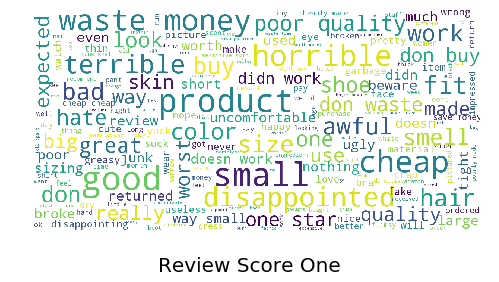

In [35]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

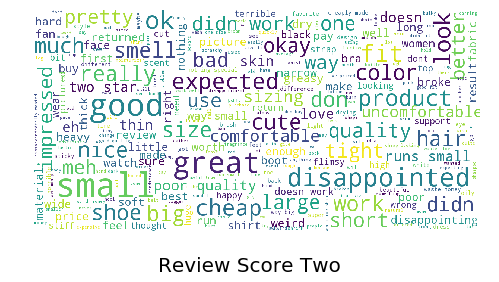

In [36]:
show_wordcloud(cluster1["summaryClean"][1] , title = "Review Score Two")

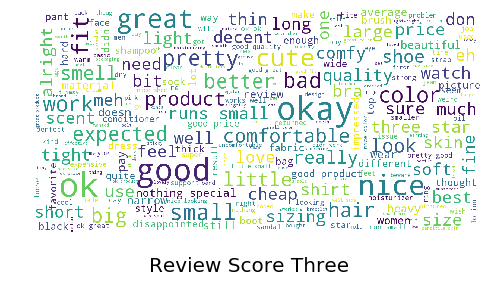

In [37]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score Three")

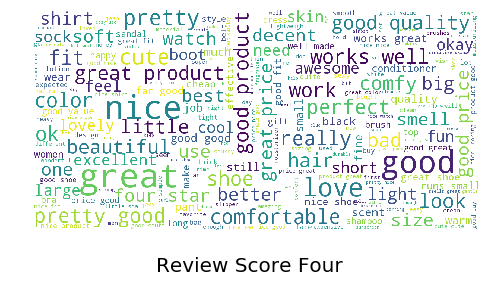

In [38]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score Four")

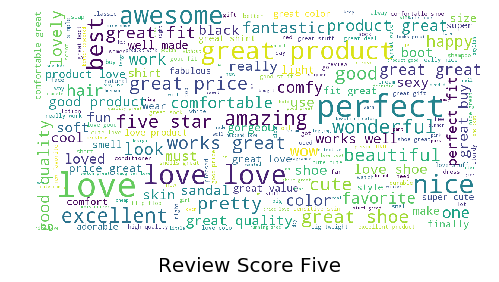

In [39]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score Five")